# Module 2: Evaluation

In the previous module, you learned how to predict user ratings. We explored two different approaches: _user-based_ and _item-based_. We discussed various _similarity measures_, including _cosine similarity_ and _euclidean similarity_. So, what is the significance of all this? Which algorithm works the best?

There is no one-size-fits-all approach for every recommendation setting. Whichever algorithm works best depends on various factors, such as the nature of the data and the specific goal of the recommender system. We can, however, investigate what works best for a specific dataset and a well-defined goal. In this module, we will determine which algorithm provides the best predictions for the MovieLens dataset.

What you developed in the previous module is an algorithm to predict ratings. However, this doesn't constitute a complete recommender system yet. Therefore, we cannot make conclusions about the resulting recommender system. Nevertheless, we can assess the quality of the predictions. To evaluate this, we will again use the MovieLens dataset, but this time with a slightly larger subset.

## Structure

- [Setup](#Setup) Get dating for testing.
    - [Offline Testing with a Test Set](#Offline-Testing-with-a-Test-Set:), [Question 1](#Question-1)
    - [Working Efficiently](#Working-Efficiently), [Pre-computed data](#Pre-computed-data)
- [Setup KNN](#Setup-KNN) Re-implement KNN. [Question 2](#Question-2)
- [Mean squared error](#Mean-squared-error) A validation metric for regression. [Question 3](#Question-3), [Question 4](#Question-4)
- [Baseline](#Baseline) How to interpret the validation scores? [Question 5](#Question-5), [Question 6](#Question-6), [Question 7](#Question-7), [Question 8](#Question-8), [Question 9](#Question-9), [Question 10](#Question-10)
- [Precision and Recall](#Precision-and-Recall) Validation metrics for classifcation.
    - [Precision](#Precision), [Question 11](#Question-11)
    - [Recall](#Recall), [Question 12](#Question-12), [Question 13](#Question-13), [Question 14](#Question-14)
    - [Precision-Recall Curve](#Precision-Recall-Curve), [Question 15](#Question-15), [Question 16](#Question-16), [Question 17](#Question-17), [Question 18](#Question-18), [Question 19](#Question-19)
- [Done](#Done)
- [Extra Concept Questions](#Extra-Concept-Questions), [Concept Question 1](#Concept-Question-1), [Concept Question 2:](#Concept-Question-2:)
   

## Setup

### Offline Testing with a Test Set:

A commonly used strategy involves splitting the data into a _training set_ and a _test set_. We learn the similarities based on the _training set_ and then make predictions for the _test set_ using the previously learned similarities. This separation is crucial because the _test set_ represents unknown data, which we did not use during the learning process. This allows us to test whether the predictions based on the learned similarities from the _training set_ also hold true for new or unknown data.

We will go through the following steps to achieve this:

* First, we will divide the data into two subsets: a _test set_ and a _training set_.
* Using the _training set_, we will create a similarity matrix.
* From this matrix, we will predict the ratings for movie/user combinations in the _test set_.
* Finally, we will compare the predicted ratings with the actual ratings from the _test set_.

### Additional Helper Functions:

Let's start by loading the necessary packages.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Course specific packages
import answers
from helpers import number_of_movies, number_of_users, number_of_ratings, rating_density, split_data

# Import from previous module
from cf1 import pivot_ratings, fill_nan_mean, create_similarity_matrix_cosine,\
                mean_center_columns, select_neighborhood, weighted_mean, mean_center_rows

If you encounter an error with the above import, it might be because you've not activated the CI conda environment. Take another look at the installation instructions; you might have missed a step.

In the previous module, you wrote several functions: `pivot_ratings`, `fill_nan_mean`, `create_similarity_matrix_cosine`, `mean_center_columns`, `select_neighborhood`, `weighted_mean`, and `mean_center_rows`.

You need these functions again now. However, they are already provided for this module in the `cf1` file. So, you don't need to copy them from the previous module.

### Load the data

Below, we load a new dataset. This dataset contains over 3000 ratings. To test the effectiveness of our algorithm, we will split the data into two parts: `ratings_t80_training` (the data we will use for prediction) and `ratings_t80_test` (the data we will use to test the accuracy of the predictions).

The dataset has a density of about 80% (hence the suffix `_t80`). This means that, on average, each user has provided ratings for 80% of the movies. Since we are setting aside a portion of the ratings for the test set, the training set retains only 60% of the data. By the way, this is quite a lot; in practice, you often don't even come close to achieving that. The data used is a subset of a much larger dataset with a density well below 1%.

In [2]:
# Load the ratings_t80
ratings_t80 = pd.read_csv('./mini-movielens/ratings_t80.csv')
ratings_t80_training, ratings_t80_test = split_data(ratings_t80)

# Show the stats
print('Stats training set:')
print(f'Number of ratings: {number_of_ratings(ratings_t80_training)}')
print(f'Number of users: {number_of_users(ratings_t80_training)}')
print(f'Number of movies: {number_of_movies(ratings_t80_training)}')
print(f'Density: {rating_density(ratings_t80_training)}')

# Display the first 5 rows of the data
display(ratings_t80.head())

Stats training set:
Number of ratings: 3006
Number of users: 25
Number of movies: 200
Density: 0.6012


userId  movieId  rating   timestamp
0      68        1     2.5  1158531426
1      68        2     2.5  1158532776
2      68       16     3.5  1158533018
3      68       47     4.0  1158531489
4      68       50     3.0  1158531764

### Question 1

\[1 pt.\]

Create a utility matrix and store it in a variable named `utility`, and create an _adjusted cosine_ similarity matrix and store it in a variable named `similarity`. Perform both of these steps for _item-based_ filtering. Utilize the functions you created in the previous module for this purpose.

In [3]:
### BEGIN SOLUTION
utility = pivot_ratings(ratings_t80_training)
utility_filled = fill_nan_mean(utility)
centered_utility = mean_center_columns(utility_filled)
similarity = create_similarity_matrix_cosine(centered_utility)
# ### END SOLUTION

display(utility.head())
display(similarity.head())

userId   68   105  177  182  232  249  274  288  298  307  ...  474  480  483  \
movieId                                                    ...                  
1        2.5  NaN  NaN  4.0  NaN  4.0  4.0  4.5  2.0  4.0  ...  4.0  NaN  NaN   
2        NaN  NaN  3.5  NaN  4.0  4.0  3.5  2.0  0.5  2.5  ...  3.0  3.0  4.0   
16       3.5  4.5  NaN  5.0  NaN  NaN  4.5  NaN  NaN  NaN  ...  4.0  4.0  4.0   
32       NaN  3.5  NaN  4.0  NaN  5.0  4.0  NaN  4.0  3.5  ...  4.0  4.0  5.0   
47       NaN  5.0  4.5  NaN  4.5  5.0  4.0  NaN  4.0  4.0  ...  NaN  4.5  3.5   

userId   590  599  600  603  606  608  610  
movieId                                     
1        4.0  3.0  2.5  4.0  2.5  NaN  NaN  
2        2.5  NaN  4.0  NaN  NaN  2.0  NaN  
16       NaN  3.0  NaN  4.0  NaN  4.5  4.5  
32       3.0  3.0  NaN  3.0  4.0  NaN  4.5  
47       3.0  4.0  4.0  NaN  3.0  4.5  5.0  

[5 rows x 25 columns]

movieId     1         2         16        32        47        50        104    \
movieId                                                                         
1        1.000000  0.168743 -0.020040 -0.096972 -0.022351  0.151485 -0.230859   
2        0.168743  1.000000 -0.482041 -0.204514 -0.463949 -0.436061  0.372800   
16      -0.020040 -0.482041  1.000000  0.113875  0.489484  0.644972 -0.309973   
32      -0.096972 -0.204514  0.113875  1.000000  0.442989  0.328448 -0.506858   
47      -0.022351 -0.463949  0.489484  0.442989  1.000000  0.349315 -0.595072   

movieId     110       153       223    ...     46578     48385     48394  \
movieId                                ...                                 
1        0.121628 -0.022195  0.176785  ... -0.032943  0.282065 -0.139659   
2        0.186018  0.613228 -0.023415  ... -0.126030  0.096443 -0.154763   
16      -0.099919 -0.418123 -0.068501  ...  0.313134  0.286079  0.062617   
32       0.119328 -0.497107 -0.034309  ...  0.343029 -0.072641  0.510843   
47      -0.168127 -0.666247 -0.332830  ...  0.094299 -0.006233  0.153809   

movieId     48516     48780     51662     52722     53125     58559     59315  
movieId                                                                        
1        0.099080  0.217189 -0.099192  0.075603 -0.160189 -0.103409  0.044789  
2       -0.407525  0.106556 -0.039754  0.462021  0.510987 -0.521303 -0.317854  
16       0.555116  0.158434  0.245228 -0.407579 -0.170303  0.492128  0.330839  
32       0.297535  0.422813  0.165825 -0.581471 -0.387422  0.506793  0.570990  
47       0.700517  0.393713  0.249888 -0.547349 -0.159551  0.628873  0.488278  

[5 rows x 200 columns]

In [4]:
answers.test_1(utility, similarity)

Check utility: success!
Check similarity: success!


### Working Efficiently

In order to efficiently manage computing time, it's nice to save your calculations occasionally so they don't have to redone every time. Building a similarity matrix can take a significant amount of computing time, especially if your computer is older or in case of an even larger dataset than the one provided above.

Therefore, it's better to perform the calculations once, save them, and reload them when needed. To achieve this, `pandas` uses the Pickle data format: it can store a lot of information in few bytes and can be loaded quickly.

In the code below, we save the matrices as a pickle file (`.pkl`), and then demonstrate how to reload them.

In [5]:
utility.to_pickle('./mini-movielens/ratings_t80_utility_student.pkl')
similarity.to_pickle('./mini-movielens/ratings_t80_similarity_student.pkl')

u = pd.read_pickle('./mini-movielens/ratings_t80_utility_student.pkl')
s = pd.read_pickle('./mini-movielens/ratings_t80_similarity_student.pkl')

pd.testing.assert_frame_equal(u, utility)
pd.testing.assert_frame_equal(s, similarity)

### Pre-computed data

For the rest of the assignment we'll be using a number of different datasets. To avoid long computations and to make sure everyone uses the same data for firther analysis, we pre-computed simliratity and utility matrices. Load the first pre-computed dataset here below:

In [6]:
ratings = pd.read_csv(f'./mini-movielens/ratings_t80.csv')[['userId', 'movieId', 'rating', 'timestamp']]

training_data = pd.read_pickle(f'./mini-movielens/ratings_t80_training.pkl')
test_data = pd.read_pickle(f'./mini-movielens/ratings_t80_test.pkl')
utility_items = pd.read_pickle(f'./mini-movielens/ratings_t80_utility_items.pkl')
similarity_items = pd.read_pickle(f'./mini-movielens/ratings_t80_similarity_items.pkl')

display(utility_items.head())
display(similarity_items.head())

print(ratings.shape, training_data.shape, test_data.shape, utility_items.shape, similarity_items.shape)

userId   68   105  177  182  232  249  274  288  298  307  ...  474  480  483  \
movieId                                                    ...                  
1        2.5  NaN  NaN  4.0  NaN  4.0  4.0  4.5  2.0  4.0  ...  4.0  NaN  NaN   
2        NaN  NaN  3.5  NaN  4.0  4.0  3.5  2.0  0.5  2.5  ...  3.0  3.0  4.0   
16       3.5  4.5  NaN  5.0  NaN  NaN  4.5  NaN  NaN  NaN  ...  4.0  4.0  4.0   
32       NaN  3.5  NaN  4.0  NaN  5.0  4.0  NaN  4.0  3.5  ...  4.0  4.0  5.0   
47       NaN  5.0  4.5  NaN  4.5  5.0  4.0  NaN  4.0  4.0  ...  NaN  4.5  3.5   

userId   590  599  600  603  606  608  610  
movieId                                     
1        4.0  3.0  2.5  4.0  2.5  NaN  NaN  
2        2.5  NaN  4.0  NaN  NaN  2.0  NaN  
16       NaN  3.0  NaN  4.0  NaN  4.5  4.5  
32       3.0  3.0  NaN  3.0  4.0  NaN  4.5  
47       3.0  4.0  4.0  NaN  3.0  4.5  5.0  

[5 rows x 25 columns]

movieId     1         2         16        32        47        50        104    \
movieId                                                                         
1        1.000000 -0.074719  0.006048 -0.123256 -0.052228  0.177143 -0.611335   
2       -0.074719  1.000000 -0.229868 -0.297085 -0.434521 -0.570727  0.176152   
16       0.006048 -0.229868  1.000000 -0.227995  0.547404  0.708517 -0.140028   
32      -0.123256 -0.297085 -0.227995  1.000000  0.276384  0.337146 -0.433426   
47      -0.052228 -0.434521  0.547404  0.276384  1.000000  0.272674 -0.714514   

movieId     110       153       223    ...     46578     48385     48394  \
movieId                                ...                                 
1        0.078965 -0.368889  0.172374  ... -0.189154  0.358179 -0.258308   
2       -0.170048  0.699054 -0.264236  ... -0.068210  0.103298  0.504474   
16      -0.071521  0.147167 -0.081598  ... -0.030113  0.191778 -0.429182   
32       0.381141 -0.268527  0.731417  ...  0.712671  0.047492  0.821246   
47       0.065212 -0.695938 -0.224932  ...  0.178282  0.297428 -0.251417   

movieId     48516     48780     51662     52722     53125     58559     59315  
movieId                                                                        
1        0.553921  0.431211 -0.331644  0.269666 -0.304307 -0.021524  0.351863  
2       -0.396351  0.563123 -0.172086  0.136263  0.495172 -0.285229 -0.143689  
16       0.712472 -0.205609  0.671984  0.455058  0.489067  0.255038 -0.264911  
32      -0.036044  0.145748  0.407662 -0.755221 -0.282205  0.521183  0.482450  
47       0.716111  0.147248  0.187771 -0.346008  0.142365  0.577807  0.322909  

[5 rows x 200 columns]

(3999, 4) (3006, 4) (993, 4) (200, 25) (200, 200)


## Setup KNN

### Question 2

\[1 pt.\]

Write a function below that predicts a rating for each rating in the _test data_. Use the same _item-based_ approach as in the previous module. (Use k = 100 for the neighborhood.)

The input to the function is the similarity matrix, the utility matrix, and the test data. The output should be the same as the test data, except with the `rating` column replaced by your calculated `predicted rating` column. The output should look like the example below:

<table border="1" class="dataframe"><thead><tr style="text-align: right;"><th></th><th>userId</th><th>movieId</th><th>predicted rating</th></tr></thead><tbody><tr><th>1</th><td>68</td><td>2</td><td>3.487983</td></tr><tr><th>3</th><td>68</td><td>47</td><td>3.457851</td></tr><tr><th>6</th><td>68</td><td>110</td><td>3.625071</td></tr><tr><th>14</th><td>68</td><td>344</td><td>3.457997</td></tr><tr><th>27</th><td>68</td><td>593</td><td>3.494299</td></tr><tr><th style="text-align: center;" colspan=5>...</th></tr></tbody></table>

In [7]:
def predict_ratings_item_based(similarity: pd.DataFrame, utility: pd.DataFrame,
                               user_item_pairs: pd.DataFrame) -> pd.DataFrame:
    display(user_item_pairs)
    ratings_test_c = user_item_pairs.copy()
    ### BEGIN SOLUTION
    ratings_test_c['predicted rating'] = pd.Series(0, index = test_data.index, dtype=float)
    for i, row in ratings_test_c.iterrows():
        userId = row['userId']
        movieId = row['movieId']
        if movieId in similarity and userId in utility:
            neighborhood = select_neighborhood(similarity[movieId], utility[userId], 100)
            ratings_test_c.at[i, 'predicted rating'] = weighted_mean(neighborhood, utility[userId])
        else:
            ratings_test_c.at[i, 'predicted rating'] = np.nan
    ratings_test_c = ratings_test_c.drop("rating", axis=1)
    return ratings_test_c

    ### END SOLUTION

actual = test_data[['userId', 'movieId', 'rating']]
    
predicted_item_based = predict_ratings_item_based(similarity_items, utility_items, actual)
display(predicted_item_based.head())

userId  movieId  rating
1         68        2     2.5
3         68       47     4.0
6         68      110     2.5
14        68      344     2.5
27        68      593     3.5
...      ...      ...     ...
3971     610     7361     5.0
3976     610     8874     5.0
3986     610    44191     3.5
3994     610    51662     4.0
3998     610    59315     4.0

[993 rows x 3 columns]

userId  movieId  predicted rating
1       68        2          3.487983
3       68       47          3.457851
6       68      110          3.625071
14      68      344          3.457997
27      68      593          3.494299

In [8]:
answers.test_2(predict_ratings_item_based, similarity_items, utility_items, test_data)

Computing solution: 

userId  movieId  rating
1         68        2     2.5
3         68       47     4.0
6         68      110     2.5
14        68      344     2.5
27        68      593     3.5
...      ...      ...     ...
3971     610     7361     5.0
3976     610     8874     5.0
3986     610    44191     3.5
3994     610    51662     4.0
3998     610    59315     4.0

[993 rows x 3 columns]

success!
Testing layout of prediction: success!
Testing values of prediction: success!


## Mean squared error

How do we measure how good the prediction is? We do this in a way that resembles determining *similarity* between movies or users. First, we calculate the deviation (the *error*) per predicted rating:

<table border="1" class="dataframe"><thead><tr style="text-align: right;"><th>user</th><th>movie</th><th>:</th><th>actual<br>rating</th><th>-</th><th>predicted<br>rating</th><th>=</th><th>difference</th></tr></thead><tbody><tr><td>68</td><td>2</td><td></td><td>2.5</td><td>-</td><td>3.487983</td><td>=</td><td>-0.99</td></tr><tr><td>68</td><td>47</td><td></td><td>4.0</td><td>-</td><td>3.457851</td><td>=</td><td>0.54</td></tr><tr><td>68</td><td>110</td><td></td><td>2.5</td><td>-</td><td>3.625071</td><td>=</td><td>-1.13</td></tr><tr><td>68</td><td>344</td><td></td><td>2.5</td><td>-</td><td>3.457997</td><td>=</td><td>-0.96</td></tr><tr><td>68</td><td>593</td><td></td><td>3.5</td><td>-</td><td>3.494299</td><td>=</td><td>0.01</td></tr><tr><th style="text-align: center;" colspan=8>...</th></tr></tbody></table>

Then, we take the average of the squares of these deviations:

$$
\textrm{mean squared error} = \frac{(-0.99)^2 + 0.54^2 + (-1.13)^2 + (-0.96)^2 + 0.01^2 + \ldots}{N}
$$

Here, $N$ is the number of items in the test set. This measure of deviation is called the **mean squared error** (mse). It's a widely used metric in data science and machine learning, and you'll encounter it often in the future.

The formal definition for enthusiasts:

$$
\textrm{mse} = \frac{1}{N}\sum_{i=1}^N(a_i - p_i)^2
$$

where $a_i$ is the actual rating and $p_i$ is the predicted rating for sample $i$.

### Question 3

\[1 pt.\]

Implement the `mse()` function below:

In [9]:
def mse(actual: pd.DataFrame, predicted: pd.DataFrame) -> float:
    ### BEGIN SOLUTION
    diff = actual['rating'] - predicted['predicted rating']
    clean = diff.dropna()
    
    sq = diff * diff
    return sq.mean()
    ### END SOLUTION

mse_item_based = mse(actual, predicted_item_based)
print(mse_item_based)

0.5995583880534643


In [10]:
answers.test_3(mse, actual, predicted_item_based)

Testing mse item based: success!


### What does this mean?

If all is well, the mean squared error for the predictions on this specific dataset should be around 0.6. Is that good? The issue with _mse_ is that the value itself doesn't convey much meaning. It's primarily useful for comparing outcomes. For example, we can compare how well _item-based filtering_ performs compared to _user-based filtering_.

### Question 4

\[1 pt.\]

Implement the `predict_ratings_user_based()` function below. The output should be similar to the `predict_ratings_item_based()` function:

<table border="1" class="dataframe"><thead><tr style="text-align: right;"><th></th><th>userId</th><th>movieId</th><th>predicted rating</th></tr></thead><tbody><tr><th>1</th><td>68</td><td>2</td><td>3.315977</td></tr><tr><th>3</th><td>68</td><td>47</td><td>4.503289</td></tr><tr><th>6</th><td>68</td><td>110</td><td>3.829485</td></tr><tr><th>14</th><td>68</td><td>344</td><td>2.926228</td></tr><tr><th style="text-align: center;" colspan=4>...</th></tr></tbody></table>

In [11]:
def predict_ratings_user_based(similarity: pd.DataFrame, utility: pd.DataFrame,
                               user_item_pairs: pd.DataFrame) -> pd.DataFrame:
    ratings_test_c = user_item_pairs.copy()
    ### BEGIN SOLUTION    
    ratings_test_c['predicted rating'] = pd.Series(0, index = test_data.index, dtype=float)
    for i, row in ratings_test_c.iterrows():
        userId = row['userId']
        movieId = row['movieId']
        if userId in similarity and movieId in utility:
            neighborhood = select_neighborhood(similarity[userId], utility[movieId], 100)
            ratings_test_c.at[i, 'predicted rating'] = weighted_mean(neighborhood, utility[movieId])
        else:
            ratings_test_c.at[i, 'predicted rating'] = np.nan
    
    ratings_test_c = ratings_test_c.drop("rating", axis=1)
    return ratings_test_c

    ### END SOLUTION
    
test_data = pd.read_pickle(f'./mini-movielens/ratings_t80_test.pkl')
utility_users = pd.read_pickle(f'./mini-movielens/ratings_t80_utility_users.pkl')
similarity_users = pd.read_pickle(f'./mini-movielens/ratings_t80_similarity_users.pkl')

actual = test_data[['userId', 'movieId', 'rating']]

predicted_user_based = predict_ratings_user_based(similarity_users, utility_users, actual)
display(predicted_user_based.head())
mse_user_based = mse(actual, predicted_user_based)
print(mse_user_based)

userId  movieId  predicted rating
1       68        2          3.315977
3       68       47          4.503289
6       68      110          3.829485
14      68      344          2.926228
27      68      593          4.323535

0.6632865685016696


In [12]:
answers.test_4(mse, actual, predicted_user_based, predicted_item_based)

Testing user based versus item based prediction: success!


## Baseline

### Better than Random?

We have now seen that item-based filtering works slightly better than user-based filtering **for this data**. However, this still doesn't give us a clear idea of how good it is.

We still lack a clear baseline. For instance, how high would the _mse_ be if we made predictions that are completely random?

### Question 5

\[1 pt.\]

Generate random ratings between `0.5` and `5.0` as predictions for each movie. Place these in the same table as before, using the `actual` table. Then, calculate the _mse_ for these predictions. Save the result in the variable `mse_random`.

In [13]:
mse_random = 0

# Pas deze tabel aan voor met jouw random voorspellingen.
predicted_random = actual.copy()

### BEGIN SOLUTION
predicted_random['predicted rating'] = np.random.rand(predicted_random.shape[0])*4.5 + 0.5
predicted_random.drop("rating", axis=1)
mse_random = mse(actual, predicted_random)
### END SOLUTION
print(f'mse for item-based prediction: {mse_item_based:.2f}')
print(f'mse for user-based prediction: {mse_user_based:.2f}')
print(f'mse for random prediction: {mse_random:.2f}')

mse for item-based prediction: 0.60
mse for user-based prediction: 0.66
mse for random prediction: 3.02


In [14]:
answers.test_5(mse_random)

Testing: success!


### Better than the Mean per Movie?

It's always good to consider multiple baselines. We could also examine how well it works to always use the average rating of a movie as the prediction.

### Question 6

\[1 pt.\]

Add the `predicted rating` column to the `predicted_item_mean` series below. Generate the average rating per movie from the _training set_ as predictions for each movie. If you need a reminder of how to do this, you should look at the previous module. You can use the `groupby()` and `aggregate()` methods along with the `np.mean()` function. Use this average rating as your predictions for the _test set_. The `join()` method will be useful for this purpose. Then, calculate the _mse_ for these predictions. Save the result in the variable `mse_item_mean`.

In [15]:
mse_item_mean = 0
predicted_item_mean = actual.copy()
### BEGIN SOLUTION
item_mean = training_data.groupby('movieId')['rating'].aggregate(np.mean)
item_mean.rename('predicted rating', inplace=True)
predicted_item_mean = predicted_item_mean.join(item_mean, on='movieId')
predicted_item_mean = predicted_item_mean.drop("rating", axis=1)
mse_item_mean = mse(actual, predicted_item_mean)
### END SOLUTION
print(f'mse for item-based prediction: {mse_item_based:.2f}')
print(f'mse for user-based prediction: {mse_user_based:.2f}')
print(f'mse for random prediction: {mse_random:.2f}')
print(f'mse for mean per item: {mse_item_mean:.2f}')

mse for item-based prediction: 0.60
mse for user-based prediction: 0.66
mse for random prediction: 3.02
mse for mean per item: 0.68


In [16]:
answers.test_6(mse_item_mean)

Testing: success!


### Distribution

We have compared the mse of three different approaches, but how are the predictions distributed exactly? Now is a great moment to visualize the predictions using some histograms. Run the code below:

     | actual | mean | item | user
-----+--------+------+------+-----
mean |   3.66 | 3.70 | 3.69 | 3.72
std  |   0.90 | 0.46 | 0.41 | 0.49


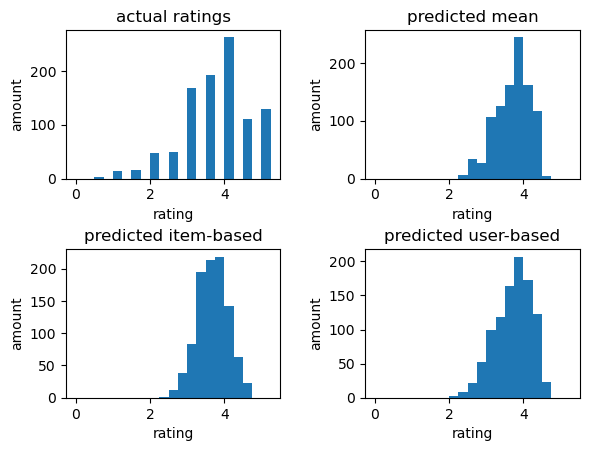

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2)
fig.tight_layout(pad=3.0)

axes = [ax1, ax2, ax3, ax4]
data = [actual['rating'], 
        predicted_item_mean['predicted rating'], 
        predicted_item_based['predicted rating'],
        predicted_user_based['predicted rating']]
titles = ["actual ratings", "predicted mean", "predicted item-based", "predicted user-based"]

for ax, d, title in zip(axes, data, titles):
    ax.hist(list(d), bins=list(np.arange(0,5.5,0.25)))
    ax.set_xlabel("rating")
    ax.set_ylabel("amount")
    ax.set_title(title)
 

print('     | actual | mean | item | user')
print('-----+--------+------+------+-----')
print(f'mean |   {data[0].mean():.2f} | {data[1].mean():.2f} | {data[2].mean():.2f} | {data[3].mean():.2f}')
print(f'std  |   {data[0].std():.2f} | {data[1].std():.2f} | {data[2].std():.2f} | {data[3].std():.2f}')

You can see that the distributions of predicted ratings for all three algorithms (item-based filtering, user-based filtering, and the mean baseline) look similar. They all have an average of around 3.70 and a standard deviation of approximately 0.45. On the other hand, the actual ratings have a much higher standard deviation (0.90).

### Question 7

\[2 pt.\]

Try to reason why the standard deviation for the predicted ratings is lower than that of the actual ratings. In other words, why are very high and low predicted ratings relatively rare?

*Answer here*

You've just seen that the *mse* of the baseline is eerily close to that of *user-based collaborative filtering*. The difference is so tiny that you wonder if it's significant. Does this mean that user-based filtering is worthless?

That's hard to say, even for this data. An important question is: how meaningful is the *mse* metric itself?

To answer this, we need to delve further into how the recommender system is used in the end. What happens in the system with the predicted rating? Is a top 10 list of items with the highest predicted ratings given? Are 20 items randomly recommended whose predicted rating is higher than 3.75? Can the user influence the recommendations?

### Recommended Items

So, we need to make some more concrete assumptions about how the recommender system works:
1. For each user, we colllect the recommended items. These are movies for which the predicted rating is higher than or equal to a certain threshold (e.g., 3.75).
2. And we collect the hidden items. These are movies with a predicted rating lower than the threshold; we do not want to recommend these.
3. Next, we present the user $N$ random movies from the recommended items. (We won't further elaborate on this assumption in this module, but it's good to know that all recommended items have an equal chance of being shown to the user.)

> With this, we turn our recommender system into a classification problem: we have two *classes*, recommended and hidden, and we want to determine under which of the two classes each movie/user pair falls. This type of problem is one you will often encounter in machine learning.

### Question 8

\[1 pt.\]

Implement the `recommended()` and `hidden()` functions below. These functions receive a DataFrame with the predicted ratings and a threshold as input. The output should be a DataFrame with all relevant combinations of `userId` and `movieId`.

In [18]:
def recommended(predictions: pd.DataFrame, threshold: float) -> pd.DataFrame:
    ### BEGIN SOLUTION
    return predictions[predictions['predicted rating'] >= threshold]
    ### END SOLUTION

def hidden(predictions: pd.DataFrame, threshold: float) -> pd.DataFrame:
    ### BEGIN SOLUTION
    return predictions[predictions['predicted rating'] < threshold]
    ### END SOLUTION
    
threshold_recommended = 3.75
recommended_items = recommended(predicted_item_based, threshold_recommended)
hidden_items = hidden(predicted_item_based, threshold_recommended)

print(f'Test items : {predicted_item_based.shape[0]}')
print(f'Recommended: {recommended_items.shape[0]}')
print(f'Hidden     : {hidden_items.shape[0]}')
display(recommended_items.head())
display(hidden_items.head())

Test items : 993
Recommended: 448
Hidden     : 545


userId  movieId  predicted rating
195     105       50          4.195964
207     105      750          4.217002
210     105      912          4.248759
217     105     1206          4.242905
218     105     1208          4.289307

userId  movieId  predicted rating
1       68        2          3.487983
3       68       47          3.457851
6       68      110          3.625071
14      68      344          3.457997
27      68      593          3.494299

In [19]:
answers.test_8(recommended, hidden, predicted_item_based, threshold_recommended)

Testing: success!


We now know which items can be recommended by the recommender system to each user in the test set. Are those recommendations justified? To assess this, we can look at the actual ratings given by the users. The assumption is that if the user gave a high rating, the recommendation was justified.

We call the items with a high enough actual rating *used* and items with a lower rating go *unused*. We can again use a threshold for this purpose. This threshold doesn't necessarily have to be the same as the threshold that splits the recommended and hidden items.

### Question 9

\[1 pt.\]

Implement the `used()` and `unused()` functions below. These functions receive a DataFrame with the actual ratings and a threshold as input. The output should be a DataFrame with all relevant combinations of `userId` and `movieId`.

In [20]:
def used(actual: pd.DataFrame, threshold: float) -> pd.DataFrame:
    ### BEGIN SOLUTION
    return actual[actual['rating'] >= threshold]
    ### END SOLUTION

def unused(actual: pd.DataFrame, threshold: float) -> pd.DataFrame:
    ### BEGIN SOLUTION
    return actual[actual['rating'] < threshold]
    ### END SOLUTION
    
threshold_used = 4.0
used_items = used(actual, threshold_used)
unused_items = unused(actual, threshold_used)

print(f'Test items: {predicted_item_based.shape[0]}')
print(f'Used      : {used_items.shape[0]}')
print(f'Unused    : {unused_items.shape[0]}')
display(used_items.head())
display(unused_items.head())

Test items: 993
Used      : 503
Unused    : 490


userId  movieId  rating
3       68       47     4.0
28      68      595     4.5
33      68      912     4.5
46      68     1197     5.0
63      68     1291     5.0

userId  movieId  rating
1       68        2     2.5
6       68      110     2.5
14      68      344     2.5
27      68      593     3.5
39      68     1073     0.5

In [21]:
answers.test_9(used, unused, actual, threshold_used)

Testing: success!


Previously, we had to make a lot of assumptions about how the recommender system functions and how to interpret the results. But now we have a bit more tools to evaluate with.

For example, we could start by looking at the number of items that were actually correctly recommended. This is the number of items that are both in the `recommended_items` and the `used_items`. We call these *true positives*. Given the four categories (recommended, hidden, used, and unused), we can determine the following values:

* **true positives**: the number of items that appear in both the *recommended items* and the *used items*.
* **false positives**: the number of items that appear in both the *recommended items* and the *unused items*.
* **true negatives**: the number of items that appear in both the *hidden items* and the *unused items*.
* **false negatives**: the number of items that appear in both the *hidden items* and the *used items*.

These four values are typically presented in a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

### Question 10

\[1 pt.\]

Implement the `confusion()` function below, taking the four selections from the previous questions (*recommended*, *hidden*, *used*, and *unused*) as input, and returning a 2x2 DataFrame with the confusion matrix.

In [22]:
def confusion(recommended: pd.DataFrame, hidden: pd.DataFrame,
              used: pd.DataFrame, unused: pd.DataFrame) -> pd.DataFrame:
    ### BEGIN SOLUTION
    tp = recommended.merge(used, how = 'inner').shape[0]
    fp = recommended.merge(unused, how = 'inner').shape[0]
    fn = hidden.merge(used, how = 'inner').shape[0]
    tn = hidden.merge(unused, how = 'inner').shape[0]
    df = pd.DataFrame(data=[[tp,fp],[fn,tn]], index=['recommended', 'hidden'], columns=['used', 'unused'])
    return df
    ### END SOLUTION

confusion_matrix = confusion(recommended_items, hidden_items, used_items, unused_items)
display(confusion_matrix)

used  unused
recommended   314     134
hidden        189     356

In [23]:
answers.test_10(confusion_matrix)

Testing: success!


## Precision and Recall

### Precision

A commonly used evaluation metric is **precision**. Precision is a measure of the question: how often is a recommended movie a relevant recommendation?

Definition:

$$
\textrm{precision} = \frac{\textrm{true positives}}{\textrm{\# recommended items}} = \frac{\textrm{true positives}}{\textrm{true positives + false positives}}
$$

So, if all the recommended movies are indeed relevant (i.e., $\textrm{false positives} = 0$), then:

$\textrm{precision} = 1$.

If none of the recommended movies are relevant (i.e., $\textrm{true positives} = 0$), then:

$\textrm{precision} = 0$.

> For more information, refer to: https://en.wikipedia.org/wiki/Precision_and_recall

### Question 11

\[1 pt.\]

Implement the `precision()` function below, taking the confusion matrix as input and returning the *precision* as output.

In [24]:
def precision(confusion_matrix: pd.DataFrame) -> float:
    ### BEGIN SOLUTION
    tp = confusion_matrix['used']['recommended']
    fp = confusion_matrix['unused']['recommended']
    return tp/(tp+fp)
    ### END SOLUTION

precision_item_based = precision(confusion_matrix)

print(f'precision for item-based prediction: {precision_item_based:.2f}')

precision for item-based prediction: 0.70


In [25]:
answers.test_11(precision_item_based)

Testing: success!


### Recall

Precision provides insight into how well the algorithm works but doesn't cover everything. Many other metrics are relevant for algorithm evaluation. One metric often used in combination with precision is *recall*.

The question central to **recall** is: How often are items that you would want to be recommended actually recommended by the algorithm? In other words, if a user would like a movie, would it be recommended to them?

Definition:

$$
\textrm{recall} = \frac{\textrm{true positives}}{\textrm{\#used items}} = \frac{\textrm{true positives}}{\textrm{true positives + false negatives}}
$$

So, if we have no false negatives (i.e., if all movies that a user would like are recommended), then: $\textrm{recall} = 1$.

### Question 12

\[1 pt.\]

Implement the `recall()` function below, taking the confusion matrix as input and returning the *recall* as output.

In [26]:
def recall(confusion_matrix: pd.DataFrame) -> float:
    ### BEGIN SOLUTION
    tp = confusion_matrix['used']['recommended']
    fn = confusion_matrix['used']['hidden']
    return tp/(tp+fn)
    ### END SOLUTION
    

recall_item_based = recall(confusion_matrix)

print(f'recall for item-based prediction: {recall_item_based:.2f}')

recall for item-based prediction: 0.62


In [27]:
answers.test_12(recall_item_based)

Testing: success!


### Question 13

\[1 pt.\]

Now we can finally compare the different approaches. Calculate the *precision* and *recall* for:
* item-based collaborative filtering
* user-based collaborative filtering
* random baseline
* mean baseline.

In [28]:
threshold_recommended = 3.75
threshold_used = 4.0

### BEGIN SOLUTION
def gen_precision_and_recall(actual, prediction, threshold_recommended, threshold_used):
    recommended_items = recommended(prediction, threshold_recommended)
    hidden_items = hidden(prediction, threshold_recommended)
    used_items = used(actual, threshold_used)
    unused_items = unused(actual, threshold_used)
    confusion_matrix = confusion(recommended_items, hidden_items, used_items, unused_items)
    return precision(confusion_matrix), recall(confusion_matrix)

precision_item_based, recall_item_based = gen_precision_and_recall(actual, predicted_item_based, threshold_recommended, threshold_used)
precision_user_based, recall_user_based = gen_precision_and_recall(actual, predicted_user_based, threshold_recommended, threshold_used)
precision_random, recall_random = gen_precision_and_recall(actual, predicted_random, threshold_recommended, threshold_used)
precision_item_mean, recall_item_mean = gen_precision_and_recall(actual, predicted_item_mean, threshold_recommended, threshold_used)
### END SOLUTION

print('           | precision | recall')
print(f'item-based |      {precision_item_based:.2f} |   {recall_item_based:.2f}')
print(f'user-based |      {precision_user_based:.2f} |   {recall_user_based:.2f}')
print(f'random     |      {precision_random:.2f} |   {recall_random:.2f}')
print(f'mean       |      {precision_item_mean:.2f} |   {recall_item_mean:.2f}')

           | precision | recall
item-based |      0.70 |   0.62
user-based |      0.66 |   0.69
random     |      0.55 |   0.34
mean       |      0.65 |   0.68


With recall, we see for the first time that item-based filtering doesn't perform as well. Both user-based filtering and mean per item have higher recall scores. Apparently, with item-based filtering, it frequently happens that a movie the user would likely want to see isn't recommended. However, even that doesn't tell us much on its own. It's likely (though not necessary) that if we lower the `threshold_recommended`, the recall would increase while the precision decreases.

### Question 14

\[2 pt.\]

Why is this likely?

*Answer here*

### Precision-Recall Curve

The performance of the algorithm depends on the `threshold_recommended` parameter. As you will often encounter, the choice of this parameter involves a trade-off between different evaluation metrics. In this case, there's a trade-off between *precision* and *recall*. In such situations, it's usual to plot a precision-recall curve. Execute the code below to see what such a curve might look like.

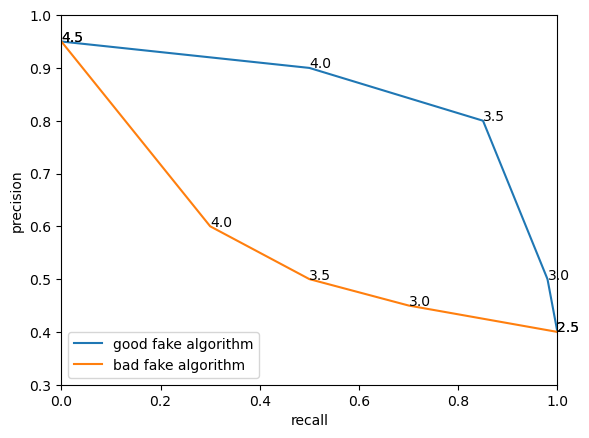

In [29]:
thresholds = [2.5, 3.0, 3.5, 4.0, 4.5]

# good fake algorithm
precisions = [0.4, 0.5, 0.8, 0.9, 0.95]
recalls = [1.0, 0.98, 0.85, 0.5, 0]
plt.plot(recalls, precisions)
for r, p, t in zip(recalls, precisions, thresholds):
    plt.text(r, p, t)

# bad fake algorithm
precisions = [0.4, 0.45, 0.5, 0.6, 0.95]
recalls = [1.0, 0.7, 0.5, 0.3, 0]
plt.plot(recalls, precisions)
for r, p, t in zip(recalls, precisions, thresholds):
    plt.text(r, p, t)

plt.xlim(0.0, 1.0)
plt.ylim(0.3, 1.0)
plt.xlabel('recall')
plt.ylabel('precision')

plt.legend(['good fake algorithm', 'bad fake algorithm'], loc = 'lower left')

In the plot above, we see the values of both *precision* and *recall* for different values of the `threshold_recommended` parameter for two _hypothetical_ algorithms. Ideally, we would want to choose the *threshold* so that both *precision* and *recall* have a value of 1. However, for neither of the algorithms, such a threshold value exists. Nevertheless, we can observe that the good algorithm (*good fake algorithm*) gets much closer. This plot provides a much more comprehensive view of how an algorithm works compared to just a single value for *precision* and *recall*.

The best value for the threshold partly depends on the application. Is *precision* or *recall* the more important metric? Is it worse to recommend movies that shouldn't be recommended, or is it worse to ignore movies that the user would have liked to see?

In this case, we can say something without delving into the specific application: For the good algorithm, there's a clear cutoff. When choosing a *threshold* lower than 3.5, precision drops significantly. Therefore, it might be best, in this setting, to set the *threshold* above 3.5.

### Question 15

\[1 pt.\]

Create a similar plot below, but now with real data. Plot the *precision-recall curves* for:
* item-based collaborative filtering
* user-based collaborative filtering
* random baseline
* mean baseline.

Keep the `threshold_used` fixed at 3.75, and use `threshold_recommended` values from 2.5 (inclusive) to 5.0 (exclusive) with increments of 0.5.

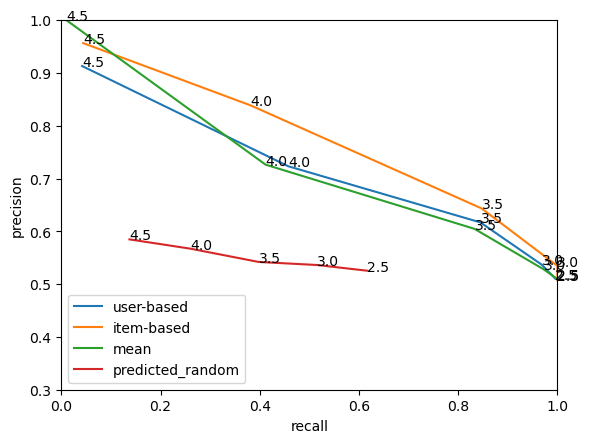

In [30]:
### BEGIN SOLUTION

for pred in [predicted_user_based, predicted_item_based, predicted_item_mean, predicted_random]:
    thresholds = np.arange(2.5,5.0,0.5)
    precisions = [gen_precision_and_recall(actual, pred, tr, 3.75)[0] for tr in thresholds]
    recalls = [gen_precision_and_recall(actual, pred, tr, 3.75)[1] for tr in thresholds]

    plt.plot(recalls, precisions)

    for r, p, t in zip(recalls, precisions, thresholds):
        plt.text(r, p, t)
    
plt.xlim(0.0, 1.0)
plt.ylim(0.3, 1.0)
plt.xlabel('recall')
plt.ylabel('precision')

plt.legend(['user-based', 'item-based', 'mean', 'predicted_random'], loc = 'lower left')

### END SOLUTION

The differences aren't as significant as in the hypothetical example, but there should be an algorithm that visibly performs better for this data.

### Question 16

\[3 pt.\]

You might notice that the precision for this data never goes lower than about 0.5. What could be the reason for this?

*Answer here*

For these algorithms, the *threshold* is an obvious parameter that can influence *precision* and *recall*. However, there are often many more parameters that affect these values (for example, the value of `k` when selecting the *neighborhood*). You could create such curves for each parameter when designing a recommender system. However, we're not going to do that now.

Let's look at one more interesting effect: the data itself. These types of algorithms are as good as the data you feed them. In this case, we've worked with a very dense dataset. For about 80% of the possible user-movie pairs, a rating is present. This is considerably denser than typically encountered when building a recommender system. This data is a subset of a much larger dataset with a density of less than 1%.

Execute the code below to load a new dataset. This set has a density of about 50%. While it's still far from as low as the original dataset, this will allow us to start examining if the density has an effect on the algorithm.

In [31]:
training_data = pd.read_pickle(f'./mini-movielens/ratings_t50_training.pkl')
test_data = pd.read_pickle(f'./mini-movielens/ratings_t50_test.pkl')
utility_items = pd.read_pickle(f'./mini-movielens/ratings_t50_utility_items.pkl')
similarity_items = pd.read_pickle(f'./mini-movielens/ratings_t50_similarity_items.pkl')
predicted_item_based_50 = predict_ratings_item_based(similarity_items, utility_items, test_data)
actual_50 = test_data[["userId", "movieId", "rating"]]

userId  movieId  rating   timestamp
1         18        6     4.0  1460138360
3         18       34     2.5  1455617533
6         18      208     3.0  1455617516
14        18      380     2.5  1455209846
27        18      924     4.0  1458516291
...      ...      ...     ...         ...
2512     597     2291     4.0   940362281
2516     597     2406     4.0   940420917
2520     597     2706     5.0   941558175
2521     597     2791     5.0   941641622
2528     597     2987     5.0   941728764

[647 rows x 4 columns]

### Question 17

\[1 pt.\]

Create a *precision-recall curve* for only *item-based filtering* using the dataset mentioned above. Plot the item-based filtering curve for the old dataset again in the same graph.

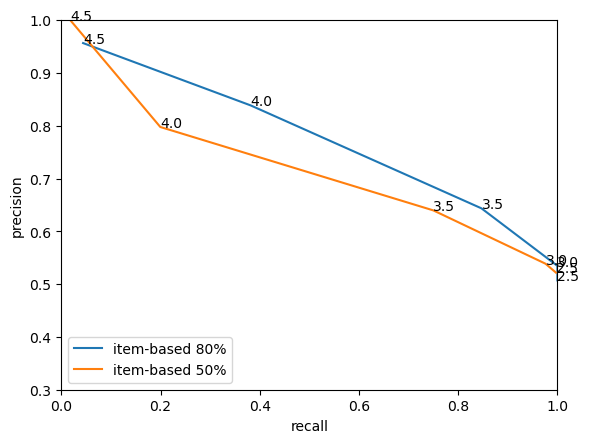

In [32]:
### BEGIN SOLUTION

for pred in [(actual, predicted_item_based), (actual_50, predicted_item_based_50)]:
    thresholds = np.arange(2.5,4.7,0.5)
    precisions = [gen_precision_and_recall(pred[0], pred[1], tr, 4.0)[0] for tr in thresholds]
    recalls = [gen_precision_and_recall(pred[0], pred[1], tr, 4.0)[1] for tr in thresholds]

    plt.plot(recalls, precisions)

    for r, p, t in zip(recalls, precisions, thresholds):
        plt.text(r, p, t)
    
plt.xlim(0.0, 1.0)
plt.ylim(0.3, 1.0)
plt.xlabel('recall')
plt.ylabel('precision')

plt.legend(['item-based 80%', 'item-based 50%'], loc = 'lower left')

### END SOLUTION

### Question 18

\[2 pt.\]

Can you provide an application of a recommender system for which precision and recall are not relevant metrics?

*Answer here*

### Question 19

\[2 pt.\]

You created a precision-recall curve for the *threshold_recommended* parameter, so we now have a fairly clear picture of the effect of that parameter on the quality of predictions. What other parameters could/should you investigate?

*Answer here*

## Done

In the previous module, you learned how to implement *item-based collaborative filtering*. You learned how to create a *utility matrix* and used it to construct a *similarity matrix*. You tried different similarity measures and ultimately worked with the *cosine similarity* to complete the algorithm. This involved determining a *neighborhood* and then calculating a weighted average for that neighborhood. After that, you saw how to apply the same techniques to *user-based* collaborative filtering.

In this module, we looked at how to *evaluate* the learned algorithms. In doing so, we focused solely on *offline testing* (using the historical data provided). To achieve this, we had to make many assumptions about user behavior. The only way to test these assumptions would be through online testing, which we cannot perform within this course but is something companies like Facebook continuously do.

There is much more to say about the topic of evaluation. It's a subject that is also relevant outside the domain of recommender systems. Many machine learning algorithms are evaluated in similar ways. For more information:

* [Wikipedia, Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)
* [Wikipedia, Recommender systems](https://en.wikipedia.org/wiki/Recommender_system#Performance_measures)
* [G. Shani, A. Gunawardana, *Evaluating Recommendation Systems*](https://www.researchgate.net/publication/226264572_Evaluating_Recommendation_Systems) (freely downloadable from the UvA network).
* [M. Ge, C. Delgado-Battenfeld, Dietmar Jannach, *Beyond Accuracy: Evaluating Recommender Systems by Coverage and Serendipity*](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.464.8494&rep=rep1&type=pdf)

### Next Module

In the last exercise, we observed that the density of the dataset affects the performance of collaborative filtering. As the density decreases, collaborative filtering becomes less effective. In the next module, we will see how to apply content-based filtering to handle this issue.

## Extra Concept Questions
You don't need to submit these questions, but they are useful practice for the exam.

### Concept Question 1
We made a lot of assumptions when testing the above algorithms. For example, an actual rating higher than 4.0 would imply that a movie is recommended correctly.

- a. Name at least two other assumptions we made when evaluating the *collaborative filtering* algorithms.
- b. Propose an online evaluation or user study that could test the validity of these assumptions.

### Concept Question 2:
The measures we covered above are widely used, but they are certainly not the only possible measures. There are countless questions we can ask about the system that the current measures don't answer. For example:
- What's the likelihood that users discover new movie genres?
- For a news media site: How likely is the case that users will end up in a filter bubble?
- How likely is it that a less popular item gets recommended?
- How diverse are the recommended movies?

Can you come up with a useful measure that hasn't been covered here? What's the definition? What question does the measure answer? Why is that question relevant?